Importing dependencies

In [41]:
# Dependencies
import numpy as np
import pandas as pd
import sys
import itertools
import math
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from scipy.stats import uniform, randint, expon
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn import svm
import pickle

Implementing My ANN

In [18]:
def sigmoid(x):
        """Computes sigmoid function

        Parameters
        ----------
        x : int or numpy.array
            Real numbers to compute sigmoid function on

        Returns
        -------
        numpy.array
            Result of sigmoid function for each element of x
        """
        return(1/(1+np.exp(-x)))

def relu(x):
        """Computes relu function

        Parameters
        ----------
        x : int or numpy.array
            Real numbers to compute relu function on

        Returns
        -------
        numpy.array
            Result of relu function for each element of x
        """
        return(np.clip(x, a_min = 0, a_max = None))

class ANN(BaseEstimator, ClassifierMixin):
    """
    A class used to represent an Artificial Neural Network

    ...

    Attributes
    ----------
    n_input : int
        a integer to indicate number of input units (features)
    n_hidden : tuple
        a tuple containing a maximum of 2 integers indicatng size of (number of units in) each hidden layer (default (5,))
    seed : int
        the random state to use for initializing weights and data shuffle (default random)
    act_h : str
        the activation function to use, on of 'sigmoid' or 'relu' (default 'relu')
    n_output : int
        a integer to indicate number of output units (default 1)
    learning_rate : float
        a real number between 0 and 1 specifyng the learning rate (default 0.05) 
    momentum : float
        a real number between 0 and 1 specifyng the momentum (default 0.9)
    tol : float
        a real number specifying a threshold for improvement in error under which early stopping occurs (default 1e-4)
    n_epoch_no_change : int
        an integer specifying the number of epochs in a row needed where improvement in error is below tol for early stopping to occure (default 10)
    batch_size : int
        the batch size for stochastic gradient descent (default 1)
    epochs : int
        the number of times each data sample is used for training (default 5)
    shuffle : bool
        whether to shuffle samples before training (default True)
    quiet : bool
        whether to output updates during training (default False)
    
        
    Methods
    -------
    fit(X_tr, y_tr = None, threshold = .5, nesterov = True, xval = None, yval = None)
        Fits the ANN class object using training data
    predict(X, y = None)
        Predicts samples using ANN class object, cannot be evoked before fit method
    score(y_true, y_pred)
        Computes negative of half the sum of squared differences between true and predicted labels
    """
    
    def __init__(self, 
               n_input, 
               n_hidden = (5,),
               seed = round(np.random.uniform()*1000), 
               act_h = 'relu',
               n_output = 1, 
               learning_rate = 0.05, 
               momentum = 0.9,
               tol = 1e-4,
               n_epoch_no_change = 10,
               batch_size = 1,
               epochs = 5,
               shuffle = True,
               quiet = False):
        """Initializes an ANN class object

            Parameters
            ----------
            n_input : int
                a integer to indicate number of input units (features)
            n_hidden : tuple, optional
                a tuple containing a maximum of 2 integers indicatng size of (number of units in) each hidden layer (default (5,))
            seed : int, optional
                the random state to use for initializing weights and data shuffle (default random)
            act_h : str, optional
                the activation function to use, on of 'sigmoid' or 'relu' (default 'relu')
            n_output : int, optional
                a integer to indicate number of output units (default 1)
            learning_rate : float, optional
                a real number between 0 and 1 specifyng the learning rate (default 0.05) 
            momentum : float, optional
                a real number between 0 and 1 specifyng the momentum (default 0.9)
            tol : float, optional
                a real number specifying a threshold for improvement in error under which early stopping occurs (default 1e-4)
            n_epoch_no_change : int, optional
                an integer specifying the number of epochs in a row needed where improvement in error is below tol for early stopping to occure (default 10)
            batch_size : int, optional
                the batch size for stochastic gradient descent (default 1)
            epochs : int, optional
                the number of times each data sample is used for training (default 5)
            shuffle : bool, optional
                whether to shuffle samples before training (default True)
            quiet : bool, optional
                whether to output updates during training (default False)

            Returns
            -------
            ANN class object
                an ANN class object of specified parameters (all are saved as object attributes)
                model contains momentum with nesterov option and minibatch stochastic gradient descent
                model does not contain bias or L2 regularization

                Additional attributes:
                n_hlayer : int
                    the number of hidden layers based on length of n_hidden
            """

        self.n_input = n_input
        self.n_hidden = n_hidden

        if(len(n_hidden) == 1):
            self.n_hlayer = 1
        else:
            self.n_hlayer = 2

        self.n_output = n_output
        self.seed = seed
        self.act_h = act_h
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.tol = tol
        self.n_epoch_no_change = n_epoch_no_change
        self.batch_size = batch_size
        self.epochs = epochs
        self.shuffle = shuffle
        self.quiet = quiet

    def predict(self, X, y = None):
        """Predicts given samples using ANN class object

        Parameters
        ----------
        X : numpy.array
            The samples to predict in a 2D array of size n_samples x n_inputs
        y : numpy.array, optional
            The true labels in a 2D array of size n_samples x n_outputs (default None)

        Returns
        -------
        numpy.array
            Predicted labels in a 2D array of size n_samples x n_outputs
        """

        if(X.shape[1] != self.n_input):
              sys.exit("Input data is of wrong dimensions.")

        else:
            if(self.act_h == 'relu'):

                    if(self.n_hlayer == 1):
                          return(sigmoid(np.matmul(relu(np.matmul(X, self.hlayer_w)), self.olayer_w)))
                    else:
                          return(sigmoid(np.matmul(relu(np.matmul(relu(np.matmul(X, self.hlayer_w)), self.hlayer_w2)), self.olayer_w)))

            else:

                    if(self.n_hlayer == 1):
                          return(sigmoid(np.matmul(sigmoid(np.matmul(X, self.hlayer_w)), self.olayer_w)))
                    else:
                          return(sigmoid(np.matmul(sigmoid(np.matmul(sigmoid(np.matmul(X, self.hlayer_w)), self.hlayer_w2)), self.olayer_w)))

    def eval(self, X):
        """Evaluates given samples using ANN class object

        Parameters
        ----------
        X : numpy.array
            The samples to evaluate in a 2D array of size n_samples x n_inputs

        Returns
        -------
        numpy.array
            Output of first hidden layer in a 2D array of size n_hidden[0] x n_samples
        numpy.array
            Output of second hidden layer in a 2D array of size n_hidden[1] x n_samples, 1 if no second layer exists
        numpy.array
            Predicted probabilities in a 2D array of size n_samples x n_outputs
        """

        if(X.shape[1] != self.n_input):
            sys.exit("Input data is of wrong dimensions.")

        else:

            if(self.act_h == 'relu'):

                    if(self.n_hlayer == 1):
                        h_out = np.matmul(X, self.hlayer_w).reshape((self.n_hidden[0], X.shape[0]))
                        h_out2 = 1
                        y_prob = sigmoid(np.matmul(relu(h_out.T), self.olayer_w))

                    else:
                        h_out = np.matmul(X, self.hlayer_w).reshape((self.n_hidden[0], X.shape[0]))
                        h_out2 = np.matmul(relu(h_out.T), self.hlayer_w2).reshape((self.n_hidden[1], X.shape[0]))
                        y_prob =  sigmoid(np.matmul(relu(h_out2.T), self.olayer_w))
            else:

                    if(self.n_hlayer == 1):
                        h_out = sigmoid(np.matmul(X, self.hlayer_w)).reshape((self.n_hidden[0], X.shape[0]))
                        h_out2 = 1
                        y_prob = sigmoid(np.matmul(h_out.T, self.olayer_w))

                    else:
                        h_out = sigmoid(np.matmul(X, self.hlayer_w)).reshape((self.n_hidden[0], X.shape[0]))
                        h_out2 = sigmoid(np.matmul(h_out.T, self.hlayer_w2)).reshape((self.n_hidden[1], X.shape[0]))
                        y_prob = sigmoid(np.matmul(h_out2.T, self.olayer_w))

        return(h_out, h_out2, y_prob)

    def score(self, y_true, y_pred):
        """Computes negative of half the sum of squared differences between true and predicted labels

        Parameters
        ----------
        y_true : numpy.array
            The true labels in a 2D array of size n_samples x 1
        y_pred : numpy.array
            The predicted labels in a 2D array of size n_samples x 1  

        Returns
        -------
        float
            negative of half the sum of squared differences
        """
        return(-(0.5*np.sum((y_true - y_pred)**2)))
  
    def fit(self, X_tr, y_tr = None, threshold = .5, nesterov = True, xval = None, yval = None):
        """
        Trains an ANN class object model using training data

        Parameters
        ----------
        X_tr : numpy.array
            The training samples in a 2D array of size n_samples x n_inputs
        y_tr : numpy.array
            The true training labels in a 2D array of size n_samples x 1 (default None)
        threshold : float, optional
            the threshold used for binary output, only used to compute accuracy (default .5)
        nesterov : bool, optional
            whether to use Nesterov's momentum or not (default True)
        xval : numpy.array, optional
            The validation samples in a 2D array of size n_samples x n_inputs, used to compute and save error at each epoch (default None)
        yval : numpy.array, optional
            The validation true labels in a 2D array of size n_samples x 1, used to compute and save error at each epoch (default None)

        Returns
        -------
        None
            Additional attributes:
            hlayer_w : numpy.array
                weights for the first hidden layer in a 2D array of size n_input x n_hidden[0]
            hlayer_w2 : numpy.array or int
                weights for the second hidden layer in a 2D array of size n_hidden[0] x n_hidden[1]
            olayer_w : numpy.array
                weights for the output layer in a 2D array of size n_hidden[0 or 1] x n_output
            pred : numpy.array
                final predicted probabilities in a 2D array of size n_samples x n_output
            min_err : float
                minimum normalized error
            best_epoch: int
                epoch at which minimum normalized error occured
            stop_err : float
                error at stopping epoch
            stop_epoch: int
                epoch at which early stopping occured
            errs: list
                training errors at each epoch
            val_errs: list, only if xval and yval not None
                validation errors at each epoch
        """
        def create_layer(i, j):
            """Creates a layer of random weights between -0.05 and 0.05 with specified dimensions i x j

                Parameters
                ----------
                i : int
                    Number of rows
                j : int
                    Number of columns

                Returns
                -------
                numpy.array
                    2D array of random weights of size i x j 
            """
            return((np.random.rand(i, j) - 0.5)/10)

        def get_error(y_hat, y):
            """Computes half of sum of squared differences between true and predicted labels

                Parameters
                ----------
                y_hat : numpy.array
                    The predicted labels in a 2D array of size n_samples x 1
                y : numpy.array
                    The true labels in a 2D array of size n_samples x 1

                Returns
                -------
                float
                    half of sum of squared differences
            """
            return(0.5*np.sum((y - y_hat)**2))

        np.random.seed(self.seed)

        if(self.n_hlayer == 1):
            self.hlayer_w = create_layer(self.n_input, self.n_hidden[0])
            self.olayer_w = create_layer(self.n_hidden[0], self.n_output)

        else:
            self.hlayer_w = create_layer(self.n_input, self.n_hidden[0])
            self.hlayer_w2 = create_layer(self.n_hidden[0], self.n_hidden[1])
            self.olayer_w = create_layer(self.n_hidden[1], self.n_output)

        y_hats = self.predict(X_tr)
        err = get_error(y_hats, y_tr)
        val = False

        if((xval is not None) and (yval is not None)):
            val = True
            y_hats_val = self.predict(xval)
            err_val = get_error(y_hats_val, yval)
            self.errs_val = [err_val/y_hats_val.shape[0]]

        if(not self.quiet):
            print("========Training Error", str(err))
            print("========Training Accuracy", str(np.mean((y_hats > threshold) == y_tr)))
            if(val):
                print("========Validation Error", str(err_val))
                print("========Validation Accuracy", str(np.mean((y_hats_val > threshold) == yval)))

        self.min_err = err/y_hats.shape[0]
        self.best_epoch = 0
        self.errs = [err/y_hats.shape[0]]

        prev_err = err
        no_change_count = 0

        for epoch in range(self.epochs):
          df = np.concatenate((X_tr, y_tr), axis = 1)

          if(self.shuffle):
          #Shuffle samples at each epoch
            np.random.seed(self.seed + epoch)
            np.random.shuffle(df)

          if(not self.quiet):
            print("====================================")
            print("Epoch", str(epoch + 1))

          prev_deltahw = 0
          prev_deltahw2 = 0
          prev_deltaow = 0

          if(self.batch_size > 1):

            for batch in np.array_split(df, df.shape[0]//self.batch_size):
              X_train = batch[:,0:self.n_input]
              y_train = batch[:,self.n_input].reshape((batch.shape[0], 1))

              if(nesterov):
                self.olayer_w += self.momentum*prev_deltaow
                self.hlayer_w += self.momentum*prev_deltahw

                if(self.n_hlayer > 1):
                  self.hlayer_w2 += self.momentum*prev_deltahw2

              h_out, h_out2, y_hat = self.eval(X_train)
              err_o = y_hat*(1 - y_hat)*(y_train - y_hat)

              if(self.act_h == 'relu'):

                if(self.n_hlayer == 1):
                  err_h = (h_out > 0).astype(int) * self.olayer_w * err_o.T
                  deltaow = self.learning_rate*(relu(h_out)@err_o)
                  self.olayer_w += deltaow + self.momentum*prev_deltaow

                else:
                  err_h2 = (h_out2 > 0).astype(int) * self.olayer_w * err_o.T
                  err_h = (h_out > 0).astype(int) * (self.hlayer_w2 @ err_h2)
                  deltaow = self.learning_rate*(relu(h_out2)@err_o)
                  self.olayer_w += deltaow + self.momentum*prev_deltaow
                  deltahw2 = (self.learning_rate*(relu(h_out)@err_h2.T))
                  self.hlayer_w2 += deltahw2 + self.momentum*prev_deltahw2

                  if(nesterov):
                    self.hlayer_w2 -= self.momentum*prev_deltahw2

                  prev_deltahw2 = deltahw2

              else:

                if(self.n_hlayer == 1):
                  err_h = h_out * (1 - h_out) * self.olayer_w * err_o.T
                  deltaow = self.learning_rate*(h_out@err_o)
                  self.olayer_w += deltaow + self.momentum*prev_deltaow

                else:
                  err_h2 = h_out2 * (1 - h_out2) * self.olayer_w * err_o.T
                  err_h = h_out * (1 - h_out) * (self.hlayer_w2 @ err_h2)
                  deltaow = self.learning_rate*(h_out2@err_o)
                  self.olayer_w += deltaow + self.momentum*prev_deltaow
                  deltahw2 = (self.learning_rate*(h_out@err_h2.T))
                  self.hlayer_w2 += deltahw2 + self.momentum*prev_deltahw2

                  if(nesterov):
                    self.hlayer_w2 -= self.momentum*prev_deltahw2

                  prev_deltahw2 = deltahw2

              deltahw = (self.learning_rate*err_h@X_train).T
              self.hlayer_w += deltahw + self.momentum*prev_deltahw

              if(nesterov):
                self.hlayer_w -= self.momentum*prev_deltahw
                self.olayer_w -= self.momentum*prev_deltaow

              prev_deltaow = deltaow
              prev_deltahw = deltahw

          else:
            #slower implementation than batch_size > 1
            X_train = df[:,0:self.n_input]
            y_train = df[:,self.n_input].reshape((df.shape[0], 1))

            for n in range(X_train.shape[0]):
              instance = X_train[n,:].reshape((1, self.n_input))

              if(nesterov):
                self.olayer_w += self.momentum*prev_deltaow
                self.hlayer_w += self.momentum*prev_deltahw

                if(self.n_hlayer > 1):
                  self.hlayer_w2 += self.momentum*prev_deltahw2

              h_out, h_out2, y_hat = self.eval(instance)
              err_o = y_hat*(1 - y_hat)*(y_train[n,:] - y_hat)

              if(self.act_h == 'relu'):

                if(self.n_hlayer == 1):
                  err_h = (h_out > 0).astype(int) * self.olayer_w * err_o
                  deltaow = self.learning_rate*err_o*relu(h_out)
                  self.olayer_w += deltaow + self.momentum*prev_deltaow

                else:
                  err_h2 = (h_out2 > 0).astype(int) * self.olayer_w * err_o
                  err_h = (h_out > 0).astype(int) * (self.hlayer_w2 @ err_h2)
                  deltaow = self.learning_rate*err_o*relu(h_out2)
                  deltahw2 = (self.learning_rate*err_h2*relu(h_out).T).T
                  self.olayer_w += deltaow + self.momentum*prev_deltaow
                  self.hlayer_w2 += deltahw2 + self.momentum*prev_deltahw2

                  if(nesterov):
                    self.hlayer_w2 -= self.momentum*prev_deltahw2

                  prev_deltahw2 = deltahw2

              else:

                if(self.n_hlayer == 1):
                  err_h = h_out * (1 - h_out) * self.olayer_w * err_o
                  deltaow = self.learning_rate*err_o*h_out
                  self.olayer_w += deltaow + self.momentum*prev_deltaow

                else:
                  err_h2 = h_out2 * (1 - h_out2) * self.olayer_w * err_o
                  err_h = h_out * (1 - h_out) * (self.hlayer_w2 @ err_h2)
                  deltaow = self.learning_rate*err_o*h_out2
                  self.olayer_w += deltaow + self.momentum*prev_deltaow
                  deltahw2 = (self.learning_rate*err_h2*h_out.T).T
                  self.hlayer_w2 += deltahw2 + self.momentum*prev_deltahw2

                  if(nesterov):
                    self.hlayer_w2 -= self.momentum*prev_deltahw2

                  prev_deltahw2 = deltahw2

              deltahw = (self.learning_rate*err_h*instance).T
              self.hlayer_w += deltahw + self.momentum*prev_deltahw

              if(nesterov):
                self.hlayer_w -= self.momentum*prev_deltahw
                self.olayer_w -= self.momentum*prev_deltaow

              prev_deltaow = deltaow
              prev_deltahw = deltahw

          y_hats = self.predict(X_tr)
          err = get_error(y_hats, y_tr)
          self.errs.append(err/y_hats.shape[0])

          if(val):
            y_hats_val = self.predict(xval)
            err_val = get_error(y_hats_val, yval)
            self.errs_val.append(err_val/y_hats_val.shape[0])

          if(err/y_hats.shape[0] < self.min_err):
            self.min_err = err/y_hats.shape[0]
            self.best_epoch = epoch

          if(not self.quiet):
            print("========Error", str(err))
            print("========Accuracy", str(np.mean((y_hats > threshold) == y_tr)))
            if(val):
              print("========Validation Error", str(err_val))
              print("========Validation Accuracy", str(np.mean((y_hats_val > threshold) == yval)))

          if(prev_err - err < self.tol):
          #record number of consecutive epochs of subthreshold improvement in error
            no_change_count += 1
          else:
            no_change_count = 0

          self.stop_epoch = epoch
          self.stop_err = err/y_hats.shape[0]

          if(no_change_count == self.n_epoch_no_change):
          #Early stopping when consecutive epochs of subthreshold improvement in error reaches n_epoch_no_change
            if(not self.quiet):
              print("========Early stopping!========")

            break

          prev_err = err

        self.pred = y_hats

        if(not self.quiet):
          print("============DONE====================")

    
    

My ANN on Disjunction of 5 Booleans

In [18]:
#Generate combinations of possible inputs
disj5 = np.array([list(numbers) for numbers in itertools.product([0, 1], repeat=5)])
#Generate result of disjunctions of inputs
disj5_y = np.array([int(np.any(i)) for i in disj5]).reshape((disj5.shape[0], 1))
print("Instances")
print(disj5)
print(disj5.shape, disj5_y.shape)

#Fit my ANN with 1 hidden unit for 100 epochs
ann = ANN(n_input = 5, 
          n_hidden = (1,),
          seed = 123, 
          act_h = 'relu', 
          learning_rate = 0.25,
          batch_size = 1,
          epochs = 100)

ann.fit(disj5, disj5_y)
print("Predictions")
ann.pred

Instances
[[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 1]
 [0 0 1 0 0]
 [0 0 1 0 1]
 [0 0 1 1 0]
 [0 0 1 1 1]
 [0 1 0 0 0]
 [0 1 0 0 1]
 [0 1 0 1 0]
 [0 1 0 1 1]
 [0 1 1 0 0]
 [0 1 1 0 1]
 [0 1 1 1 0]
 [0 1 1 1 1]
 [1 0 0 0 0]
 [1 0 0 0 1]
 [1 0 0 1 0]
 [1 0 0 1 1]
 [1 0 1 0 0]
 [1 0 1 0 1]
 [1 0 1 1 0]
 [1 0 1 1 1]
 [1 1 0 0 0]
 [1 1 0 0 1]
 [1 1 0 1 0]
 [1 1 0 1 1]
 [1 1 1 0 0]
 [1 1 1 0 1]
 [1 1 1 1 0]
 [1 1 1 1 1]]
(32, 5) (32, 1)
========Training Error 4.000265088614569
========Training Accuracy 0.03125
Epoch 1
========Error 3.9998076156619065
========Accuracy 0.40625
Epoch 2
========Error 3.9970448465694424
========Accuracy 0.75
Epoch 3
========Error 3.8798738426356887
========Accuracy 1.0
Epoch 4
========Error 1.598989560470874
========Accuracy 1.0
Epoch 5
========Error 0.5468080963554875
========Accuracy 1.0
Epoch 6
========Error 0.35311903337239486
========Accuracy 1.0
Epoch 7
========Error 0.2764755191406224
========Accuracy 1.0
Epoch 8
========Error 0.2375355774402333
==

array([[0.5       ],
       [0.96150057],
       [0.96229811],
       [0.99843369],
       [0.96139514],
       [0.99839473],
       [0.99842924],
       [0.99993701],
       [0.96086985],
       [0.99837204],
       [0.99840703],
       [0.99993612],
       [0.99836741],
       [0.99993453],
       [0.99993594],
       [0.99999743],
       [0.96212416],
       [0.99842619],
       [0.99846002],
       [0.99993825],
       [0.99842172],
       [0.99993671],
       [0.99993807],
       [0.99999752],
       [0.9983994 ],
       [0.99993581],
       [0.99993719],
       [0.99999749],
       [0.99993563],
       [0.99999742],
       [0.99999748],
       [0.9999999 ]])

Importing Steinmetz Data and K-Fold splits

In [19]:
df_tr = np.array(pd.read_csv("data_transformed_train.csv", index_col = 0))
splits = pd.read_csv('splits10by10.csv', index_col = 0).reset_index(drop = True) - 1

X_train = df_tr[:,0:20]
y_train = df_tr[:,20].reshape((X_train.shape[0],1))
print(X_train.shape, y_train.shape)

(7012, 20) (7012, 1)


In [20]:
df_te = np.array(pd.read_csv("data_transformed_test.csv", index_col = 0))

X_test = df_te[:,0:20]
y_test = df_te[:,20].reshape((X_test.shape[0],1))
print(X_test.shape, y_test.shape)

(1038, 20) (1038, 1)


Tuning My ANN, sklearn MLPC, and SVM on Steinmetz Data

In [21]:
def inv_squared_diff(y_true, y_pred):
    """Computes the sum of squared differences for true and predicted labels.
       The score is negative to be maximized instead of minimized.

    Parameters
    ----------
    y_true : numpy.array
        The true labels
    y_pred : numpy.array
        The predicted label

    Returns
    -------
    float
        The negative of the sum of squared differences
    """
    return(-(0.5*np.sum((y_true - y_pred)**2)))

def save_object(obj, filename):
    """Saved python object as pickle file to current directory

    Parameters
    ----------
    obj : any
        The python object to save
    filename : str
        The file name to use for .pkl file (format: '_.pkl')

    Returns
    -------
    None
    """
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
        
def read_object(name):
    """Read pickle file as python object from current directory

    Parameters
    ----------
    name : str
        The .pkl file name excluding '.pkl' extension (format: name.pkl)

    Returns
    -------
    any
        The python object contained in the pickle file
    """
    fName = str(name + '.pkl')
    with open(fName, 'rb') as f:  # with statement avoids file leak
        return pickle.load(f)

In [20]:
#Define parameters/distributions to tune over with RandomizedSearchCV
n_units = [1, 3, 6, 10, 15, 20] 
params = dict(my_ann__learning_rate = uniform(0, 0.2), 
              my_ann__momentum = uniform(),
              my_ann__act_h = ['relu', 'sigmoid'],
              my_ann__n_hidden = [tuple(i) for i in itertools.product(n_units, repeat=2)] + [tuple([i]) for i in n_units], #Create combinations of n_units for single and double layer ANNs
              my_ann__batch_size = randint(1, math.ceil(math.floor(X_train.shape[0]*0.9)/2)))
params_sk = dict(mlpc__learning_rate_init = uniform(0, 0.2),
              mlpc__momentum = uniform(),
              mlpc__hidden_layer_sizes = [tuple(i) for i in itertools.product(n_units, repeat=2)] + [tuple([i]) for i in n_units], #Create combinations of n_units for single and double layer ANNs
              mlpc__activation = ['relu', 'logistic'],
              mlpc__batch_size = randint(1, math.ceil(math.floor(X_train.shape[0]*0.9)/2))) #From 1 to around half the total training sample size
params_svm = [dict(svc__kernel = ['poly'],
              svc__degree = randint(1,4),
              svc__C = expon(0,7),
              svc__gamma = uniform()), 
              dict(svc__kernel = ['rbf'],
               svc__C = expon(0,7),
              svc__gamma = uniform()),
              dict(svc__kernel = ['sigmoid'],
              svc__C = expon(0,7),
              svc__gamma = uniform())]
scorer = make_scorer(inv_squared_diff, needs_proba = True) #Make common scorer to be maximized by search

searches = list()
searches_sk = list()
#searches_svm = list()

n_iter = 3
max_epochs = 100
for i in range(n_iter):
    #Tune each model n_iter times using same folds as C5.0 CV.
    #Each fold is scaled before use
    #Initialize models differently each time but keep randomly sampled params constant
  print("======================")
  print("Iteration", str(i + 1))
  group_kfold = GroupKFold(n_splits=10)
  steps = [('scaler', StandardScaler(with_mean = False)), 
           ('my_ann', ANN(n_input = 20, epochs = max_epochs, seed = 123 + i, quiet = True))]
  steps_sk = [('scaler', StandardScaler(with_mean = False)), 
           ('mlpc', MLPClassifier(solver = 'sgd', random_state = 123 + i, max_iter = max_epochs))]
  steps_svm = [('scaler', StandardScaler(with_mean = False)), 
           ('svc', svm.SVC(probability = True, random_state = 123 + i))]
  pipeline = Pipeline(steps)
  pipeline_sk = Pipeline(steps_sk)
  pipeline_svm = Pipeline(steps_svm)

  myAnnCV = RandomizedSearchCV(pipeline, params, random_state = 123, return_train_score = True, cv = group_kfold, n_jobs = 2, verbose = 1)
  skAnnCV = RandomizedSearchCV(pipeline_sk, params_sk, random_state = 123, return_train_score = True, cv = group_kfold, n_jobs = 2, scoring = scorer, verbose = 1)
  #SVM was tuned separately for time using same protocol with some mistakes (could not rerun for time)
  #svmCV = RandomizedSearchCV(pipeline_svm, params_svm, random_state = 123, return_train_score = True, cv = group_kfold, n_jobs = 2, scoring = scorer, verbose = 1)
  
  searches.append(myAnnCV.fit(X_train, y_train, groups = splits.iloc[:,i].tolist()))
  searches_sk.append(skAnnCV.fit(X_train, np.ravel(y_train), groups = splits.iloc[:,i].tolist()))
  #searches_svm.append(svmCV.fit(X_train, np.ravel(y_train), groups = splits.iloc[:,i].tolist()))
    
print("======================")
print("====Done====")

save_object(searches, 'searches.pkl')
save_object(searches_sk, 'searches_sk.pkl')
#save_object(searches_svm, 'searches_svm.pkl')

Iteration 1
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:56: RuntimeWarning: overflow encountered in exp
/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:82: RuntimeWarning: overflow encountered in exp
/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:56: RuntimeWarning: overflow encountered in exp
/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:82: RuntimeWarning: overflow encountered in exp
/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:82: RuntimeWarning: overflow encountered in exp
/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:56: RuntimeWarning: overflow encountered in exp


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Iteration 2
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:82: RuntimeWarning: overflow encountered in exp
/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:82: RuntimeWarning: overflow encountered in exp
/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:56: RuntimeWarning: overflow encountered in exp
/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:82: RuntimeWarning: overflow encountered in exp
/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:56: RuntimeWarning: overflow encountered in exp
/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:82: RuntimeWarning: overflow encountered in exp
/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:56: RuntimeWarning: overflow encountered in exp


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Iteration 3
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:82: RuntimeWarning: overflow encountered in exp
/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:82: RuntimeWarning: overflow encountered in exp
/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:82: RuntimeWarning: overflow encountered in exp
/var/folders/9n/c4d07xnn5bggw283th1gs7h00000gn/T/ipykernel_847/1034841128.py:56: RuntimeWarning: overflow encountered in exp


Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

====Done====


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [31]:
#searches_svm = read_object('searches_svm')

In [23]:
print('My Ann')
print(searches[0].best_params_)
print(searches[1].best_params_)
print(searches[2].best_params_)

My Ann
{'my_ann__act_h': 'relu', 'my_ann__batch_size': 1347, 'my_ann__learning_rate': 0.04537029071284063, 'my_ann__momentum': 0.5513147690828912, 'my_ann__n_hidden': (10, 3)}
{'my_ann__act_h': 'relu', 'my_ann__batch_size': 1347, 'my_ann__learning_rate': 0.04537029071284063, 'my_ann__momentum': 0.5513147690828912, 'my_ann__n_hidden': (10, 3)}
{'my_ann__act_h': 'relu', 'my_ann__batch_size': 1347, 'my_ann__learning_rate': 0.04537029071284063, 'my_ann__momentum': 0.5513147690828912, 'my_ann__n_hidden': (10, 3)}


In [87]:
print('MLPC')
print(searches_sk[0].best_params_)
print(searches_sk[1].best_params_)
print(searches_sk[2].best_params_)
#-pd.concat([pd.DataFrame(searches_sk[i].cv_results_).iloc[searches_sk[i].best_index_,:] for i in range(3)], axis = 1).loc['mean_test_score',:] 

MLPC
{'mlpc__activation': 'logistic', 'mlpc__batch_size': 74, 'mlpc__hidden_layer_sizes': (20, 6), 'mlpc__learning_rate_init': 0.06863560323017388, 'mlpc__momentum': 0.7290497073840416}
{'mlpc__activation': 'logistic', 'mlpc__batch_size': 74, 'mlpc__hidden_layer_sizes': (20, 6), 'mlpc__learning_rate_init': 0.06863560323017388, 'mlpc__momentum': 0.7290497073840416}
{'mlpc__activation': 'logistic', 'mlpc__batch_size': 74, 'mlpc__hidden_layer_sizes': (20, 6), 'mlpc__learning_rate_init': 0.06863560323017388, 'mlpc__momentum': 0.7290497073840416}


In [23]:
print('SVM')
print(searches_svm[0].best_params_)
print(searches_svm[1].best_params_)
print(searches_svm[2].best_params_)

SVM
{'svc__C': 27.656874481703028, 'svc__gamma': 0.6848297385848633, 'svc__kernel': 'rbf'}
{'svc__C': 27.656874481703028, 'svc__gamma': 0.6848297385848633, 'svc__kernel': 'rbf'}
{'svc__C': 27.656874481703028, 'svc__gamma': 0.6848297385848633, 'svc__kernel': 'rbf'}


Training with best parameters

In [24]:
def calc_metrics(y_true, y_pred):
    """Computes confusion matrix, accuracy, precision, recall, specificity, f1-score, and AUC for true and predicted labels

    Parameters
    ----------
    y_true : numpy.array
        The true labels
    y_pred : numpy.array
        The predicted label

    Returns
    -------
    tuple
        The first element is a confusion matrix, the second is a dictionary of remaining metrics
    """
    cm = confusion_matrix(np.ravel(y_true), y_pred.astype('int32'))
    acc = np.mean(y_true == y_pred.astype('int32'))
    auc = roc_auc_score(np.ravel(y_true), y_pred.astype('int32'))
    tn = cm[0,0]
    fn = cm[1,0]
    tp = cm[1,1]
    fp = cm[0,1]
    
    if(tp + fp == 0):
        precision = np.nan
    else:
        precision = tp/(tp + fp)
        
    if(tp + fn == 0):
        recall = np.nan
    else:
        recall = tp/(tp + fn)
    
    if(tn + fp == 0):
        specificity = np.nan
    else:
        specificity = tn/(tn + fp)
        
    if(precision + recall == 0):
        f1 = np.nan
    else:
        f1 = 2 * ((precision * recall)/(precision + recall))
    
    return((cm, {'Accuracy': [acc], 'AUC': [auc], 'Precision': [precision], 'Recall': [recall], 'Specificity': [specificity], 'F1-score': [f1]}))

In [32]:
def get_classes(y_prob, threshold = .5):
    return(np.array([1 if i > threshold else 0 for i in y_prob]))

model_errs_tr = list()
model_errs_val = list()
model_epoch = list()

errs_tr_myann = list()
errs_val_myann = list()

errs_tr_mlpc = list()
errs_val_mlpc = list()

errs_tr_svm = list()
errs_val_svm = list()

n_iter = 10
n_folds = 10
tuned_params = searches[0].best_params_
tuned_params_sk = searches_sk[0].best_params_
tuned_params_svm = searches_svm[0].best_params_

scores_myanns = pd.DataFrame()
scores_mlpcs = pd.DataFrame()
scores_svms = pd.DataFrame()
cms = dict()
cms['MyANN'] = []
cms['MLPC'] = []
cms['SVM'] = []

for i in range(n_iter):
    #Retrain models using best parameters on all training set and compute testing metrics n_iter times
    #Vary model initialization
    print("======================")
    print("Iteration", str(i + 1))
    groups = splits.iloc[:,i].tolist()
    group_kfold = GroupKFold(n_splits=n_folds)
    scaler = StandardScaler(with_mean = False)
    steps_myann = [('scaler', scaler), 
           ('my_ann', ANN(n_input = 20, n_hidden = tuned_params['my_ann__n_hidden'], act_h = tuned_params['my_ann__act_h'], momentum = tuned_params['my_ann__momentum'], learning_rate = tuned_params['my_ann__learning_rate'], seed = 123 + i, epochs = 100, quiet = True)
        )]
    steps_sk = [('scaler', scaler), 
           ('mlpc', MLPClassifier(batch_size = tuned_params_sk['mlpc__batch_size'], learning_rate_init = tuned_params_sk['mlpc__learning_rate_init'], momentum = tuned_params_sk['mlpc__momentum'], hidden_layer_sizes = tuned_params_sk['mlpc__hidden_layer_sizes'], activation = tuned_params_sk['mlpc__activation'], solver = 'sgd', learning_rate = 'constant', alpha = 0, random_state = 123 + i, max_iter = 100)
        )]
    steps_svm = [('scaler', scaler), 
           ('svc', svm.SVC(kernel = tuned_params_svm['svc__kernel'], gamma = tuned_params_svm['svc__gamma'], C = tuned_params_svm['svc__C'], random_state = 123 + i)
        )]
    steps_svm_proba = [('scaler', scaler), 
           ('svc', svm.SVC(kernel = tuned_params_svm['svc__kernel'], gamma = tuned_params_svm['svc__gamma'], C = tuned_params_svm['svc__C'], probability = True, random_state = 123 + i)
        )]
    
    #Initialize pipelines
    ann = Pipeline(steps_myann)
    mlpc = Pipeline(steps_sk)
    svc = Pipeline(steps_svm)
    
    #Fit models on all training and validation data
    ann.fit(X_train, y_train, my_ann__nesterov = True)
    mlpc.fit(X_train, np.ravel(y_train))
    svc.fit(X_train, np.ravel(y_train))
    
    #Get predictions
    y_hat_myann = get_classes(ann.predict(X_test))
    y_hat_mlpc = mlpc.predict(X_test)
    y_hat_svm = svc.predict(X_test)
    
    #Get scores
    ann_cm, ann_scores = calc_metrics(np.ravel(y_test), y_hat_myann)
    mlpc_cm, mlpc_scores = calc_metrics(np.ravel(y_test), y_hat_mlpc)
    svm_cm, svm_scores = calc_metrics(np.ravel(y_test), y_hat_svm)
    
    cms['MyANN'].append(ann_cm)
    cms['MLPC'].append(mlpc_cm)
    cms['SVM'].append(svm_cm)
    
    scores_myanns = pd.concat([scores_myanns, pd.DataFrame(ann_scores)], axis = 0)
    scores_mlpcs = pd.concat([scores_mlpcs, pd.DataFrame(mlpc_scores)], axis = 0)
    scores_svms = pd.concat([scores_svms, pd.DataFrame(svm_scores)], axis = 0)
    
    for tr_index, val_index in group_kfold.split(X_train, y_train, groups):
        #Cross-validate error for models using best parameters
        #Vary model initialization at each outer iteration and training data at each inner iteration (fold)
        #Folds used are the same as C5.0
        
        #Initialize pipelines
        ann = Pipeline(steps_myann)
        mlpc = Pipeline(steps_sk)
        svc = Pipeline(steps_svm_proba)
        
        #Fit models on training data only
        ann.fit(X_train[tr_index,:], y_train[tr_index,:], my_ann__nesterov = True, my_ann__xval = X_train[val_index,:], my_ann__yval = y_train[val_index,:])
        mlpc.fit(X_train[tr_index,:], np.ravel(y_train[tr_index,:]))
        svc.fit(X_train[tr_index,:], np.ravel(y_train[tr_index,:]))
        
        #Errors/epoch for my ann only
        model_errs_tr.append(ann[-1].errs)
        model_errs_val.append(ann[-1].errs_val)
        model_epoch.append(np.arange(0, ann[-1].stop_epoch + 2).tolist())
           
        #Erros/fold for my ANN
        errs_tr_myann.append(ann[-1].stop_err)
        errs_val_myann.append(ann[-1].errs_val[-1])
                
        #Errors/fold for sklearn MLPC
        y_hat_tr_mlpc = mlpc.predict_proba(X_train[tr_index,:])
        y_hat_val_mlpc = mlpc.predict_proba(X_train[val_index,:])
        errs_tr_mlpc.append(-inv_squared_diff(y_train[tr_index,:], y_hat_tr_mlpc))
        errs_val_mlpc.append(-inv_squared_diff(y_train[val_index,:], y_hat_val_mlpc))
        
        #Errors/fold for svm
        y_hat_tr_svm = svc.predict_proba(X_train[tr_index,:])
        y_hat_val_svm = svc.predict_proba(X_train[val_index,:])
        errs_tr_svm.append(-inv_squared_diff(y_train[tr_index,:], y_hat_tr_svm))
        errs_val_svm.append(-inv_squared_diff(y_train[val_index,:], y_hat_val_svm))

print("======================")
print("====Done====")

Iteration 1


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Iteration 2


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Iteration 3


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Iteration 4


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Iteration 5


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Iteration 6


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Iteration 7


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Iteration 8


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Iteration 9


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Iteration 10


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

====Done====


In [33]:
#Get mean and sd of each testing metric (over 10 models) and append those of C5.0
scores_myanns_stats = scores_myanns.describe()
scores_mlpcs_stats = scores_mlpcs.describe()
scores_svms_stats = scores_svms.describe()
scores_myanns_stats_all = pd.concat([scores_myanns_stats.iloc[1,:], scores_myanns_stats.iloc[2,:]], axis = 1)
scores_myanns_stats_all.columns = ['MyANN_mean', 'MyANN_sd']
scores_mlpcs_stats_all = pd.concat([scores_mlpcs_stats.iloc[1,:], scores_mlpcs_stats.iloc[2,:]], axis = 1)
scores_mlpcs_stats_all.columns = ['MLPC_mean', 'MLPC_sd']
scores_svms_stats_all = pd.concat([scores_svms_stats.iloc[1,:], scores_svms_stats.iloc[2,:]], axis = 1)
scores_svms_stats_all.columns = ['SVM_mean', 'SVM_sd']
C5_res = pd.DataFrame({'C5_mean': [0.6345793,  0.6578815, 0.6782691, 0.6849358, 0.5718947, 0.6797293],
                                      'C5_sd': [0.011881114, 0.006619025, 0.059239607, 0.012524511, 0.021594433, 0.026746076]
                                     })
C5_res.index = ['Accuracy', 'AUC', 'Precision', 'Recall', 'Specificity', 'F1-score']
scores_agg = pd.concat([scores_myanns_stats_all,
                        scores_mlpcs_stats_all,
                        scores_svms_stats_all,
                        C5_res], axis = 1)

#Get errors of each model and erros/epoch of my ANN
err_per_epoch = pd.DataFrame({'epoch': list(itertools.chain(*model_epoch)), 'train_error': list(itertools.chain(*model_errs_tr)), 'val_error': list(itertools.chain(*model_errs_val))})
errs_myann = pd.DataFrame({'train_error': errs_tr_myann, 'val_error': errs_val_myann})
errs_mlpc = pd.DataFrame({'train_error': errs_tr_mlpc, 'val_error': errs_val_mlpc})
errs_svm = pd.DataFrame({'train_error': errs_tr_svm, 'val_error': errs_val_svm})

#Get mean and sd of errors (over 100 models)
err_per_epoch_agg = err_per_epoch.groupby('epoch').agg([np.nanmean, np.nanstd])
errs_myann_agg = errs_myann.agg([np.nanmean, np.nanstd])
errs_mlpc_agg = errs_mlpc.agg([np.nanmean, np.nanstd])
errs_svm_agg = errs_svm.agg([np.nanmean, np.nanstd])
errs_agg = pd.concat([errs_myann_agg.add_suffix('_myann'), errs_mlpc_agg.add_suffix('_mlpc'), errs_svm_agg.add_suffix('_svm')], axis = 1).T


In [34]:
scores_agg

,MyANN_mean,MyANN_sd,MLPC_mean,MLPC_sd,SVM_mean,SVM_sd,C5_mean,C5_sd
Accuracy,0.585260,0.085088,0.640462,0.008285,0.579961,0.000000e+00,0.634579,0.011881
AUC,0.596696,0.052091,0.630110,0.006422,0.575884,0.000000e+00,0.657882,0.006619
Precision,0.683477,0.014628,0.683621,0.008834,0.644007,0.000000e+00,0.678269,0.059240
Recall,0.520603,0.275550,0.698995,0.038539,0.603015,0.000000e+00,0.684936,0.012525
Specificity,0.672789,0.175883,0.561224,0.039583,0.548753,1.170278e-16,0.571895,0.021594
F1-score,0.666225,0.013330,0.690569,0.015774,0.622837,0.000000e+00,0.679729,0.026746


In [35]:

err_per_epoch_agg

train_error           val_error          
          nanmean    nanstd   nanmean    nanstd
epoch                                          
0        0.124996  0.000017  0.124996  0.000023
1        0.114449  0.007463  0.125247  0.001357
2        0.111212  0.007787  0.130025  0.015945
3        0.110135  0.008146  0.137313  0.031505
4        0.109375  0.009225  0.148373  0.052055
...           ...       ...       ...       ...
96       0.104916  0.009851  0.159892  0.049162
97       0.104732  0.009872  0.160723  0.049425
98       0.104894  0.009846  0.159464  0.049747
99       0.104987  0.009788  0.158383  0.048185
100      0.104757  0.009799  0.160169  0.050223

[101 rows x 4 columns]

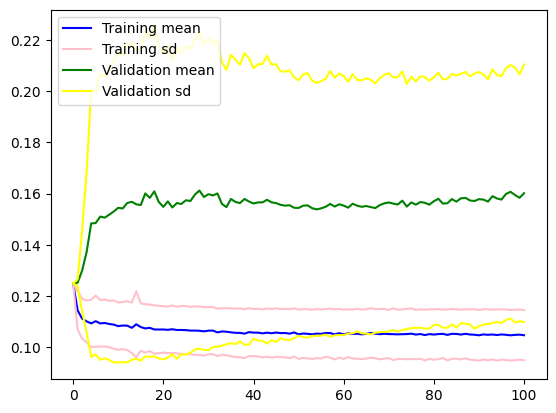

In [42]:
plt.figure()
plt.plot(err_per_epoch_agg.train_error.nanmean, color = 'blue', label = "Training mean")
plt.plot(err_per_epoch_agg.train_error.nanmean + err_per_epoch_agg.train_error.nanstd, color = 'pink', label = "Training sd")
plt.plot(err_per_epoch_agg.train_error.nanmean - err_per_epoch_agg.train_error.nanstd, color = 'pink')
plt.plot(err_per_epoch_agg.val_error.nanmean, color = 'green', label = "Validation mean")
plt.plot(err_per_epoch_agg.val_error.nanmean + err_per_epoch_agg.val_error.nanstd, color = 'yellow', label = "Validation sd")
plt.plot(err_per_epoch_agg.val_error.nanmean - err_per_epoch_agg.val_error.nanstd, color = 'yellow')
plt.legend()

In [43]:
errs_agg

,nanmean,nanstd
train_error_myann,0.105972,0.010655
val_error_myann,0.158058,0.049396
train_error_mlpc,2033.079385,64.550582
val_error_mlpc,225.816542,7.334111
train_error_svm,1911.171079,14.382303
val_error_svm,206.574329,1.872679
